# Máster en Finzas Cuantitativas

**Prueba de Evaluación

**1.Stock market returns and volatility

**Reproducir el código que viene a continuación obteniendo los resultados para Apple stock (ticker es `AAPL`)
** ¿ Que distribución - Normal o T student -  se ajusta mejor a los datos?
   
**2. Value at Risk using the historical bootstrap method

**Reproducir el código que viene a continuación obteniendo los resultados para Apple stock (ticker is `AAPL`)
**Explicar el Significado del Resultado obtenido.
**Estimar el VaR al 1% y a un día.
  
**3.Value at Risk using the variance-covariance method 

**Reproducir el código que viene a continuación obteniendo los resultados para Apple stock (ticker es `AAPL`)
**Explicar el Significado del Resultado obtenido.
**Estimar el VaR al 1% y a un día.

**4. Value at Risk using the Monte Carlo method

**Reproducir el código que viene a continuación.
  
**5. Correlation between stocks
  Reproducir el código que viene a continuación obteniendo los resultados paralos dos índices distintos.
  Los ticker de los distintos índices se pueden encontrar en https://finance.yahoo.com/world-indices
  Explicar el Significado del Resultado obtenido.
  ¿Como podemos solucionar el problema de generar una muestra de valores que respete la correlación entre las variables ?



In [1]:
import numpy
import pandas
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

## 1.Stock market returns and volatility

It's possible to download data from Yahoo Finance, thanks to the yahoofinancials library which you will need to install with a command such as

> pip install yahoofinancials

Here is a function that obtains stock data and places it in a pandas DataFrame so that we can analyze it. 

In [2]:
from yahoofinancials import YahooFinancials
from datetime import datetime

def retrieve_stock_data(ticker, start, end):
    json = YahooFinancials(ticker).get_historical_price_data(start, end, "daily")
    df = pandas.DataFrame(columns=["open","close","adjclose"])
    for row in json[ticker]["prices"]:
        date = datetime.fromisoformat(row["formatted_date"])
        df.loc[date] = [row["open"], row["close"], row["adjclose"]]
    df.index.name = "date"
    return df

Let’s download some stock market data for Microsoft (stock market ticker is `MSFT`) for the year 2018 and plot its evolution over time. We plot the *adjusted close*, which means the price at the close of each day of trading, adjusted for any events such as dividends, stock splits and new stock offerings during that day.

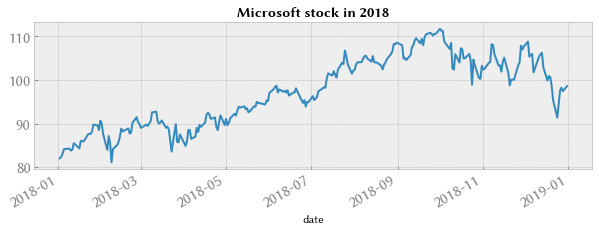

In [3]:
MSFT = retrieve_stock_data("MSFT", "2018-01-01", "2019-01-01")
fig = plt.figure()
fig.set_size_inches(10,3)
MSFT["adjclose"].plot()
plt.title("Microsoft stock in 2018", weight="bold");

For risk analysis we are more interested in daily changes than in the absolute value of the stock, so we plot the daily returns on the stock.

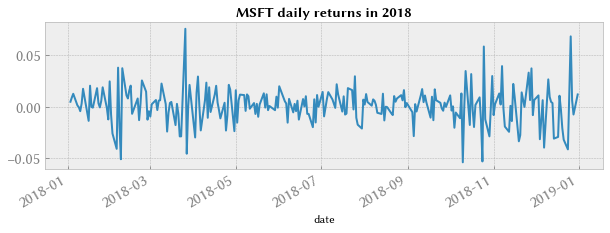

In [4]:
fig = plt.figure()
fig.set_size_inches(10,3)
MSFT["adjclose"].pct_change().plot()
plt.title("MSFT daily returns in 2018", weight="bold");

0.017838640238737418

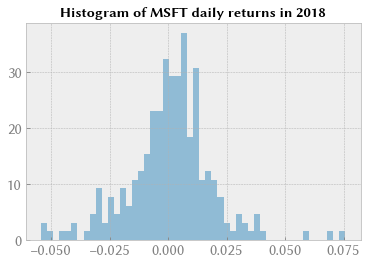

In [5]:
MSFT["adjclose"].pct_change().hist(bins=50, density=True, histtype="stepfilled", alpha=0.5)
plt.title("Histogram of MSFT daily returns in 2018", weight="bold")
MSFT["adjclose"].pct_change().std()

Let’s see whether the daily returns are better represented by a normal distribution or by a Student-t distribution.

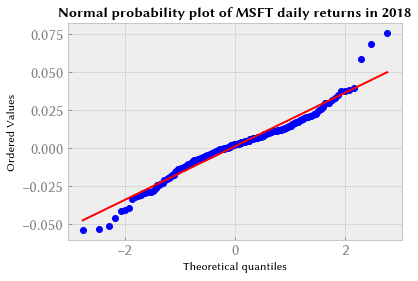

In [6]:
Q = MSFT["adjclose"].pct_change().dropna()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title("Normal probability plot of MSFT daily returns in 2018", weight="bold");

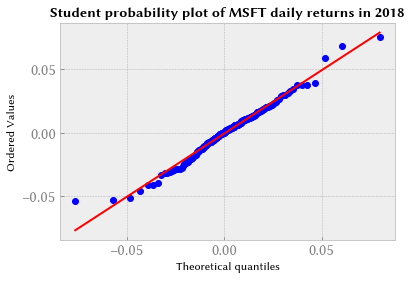

In [7]:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title("Student probability plot of MSFT daily returns in 2018", weight="bold");

**Student’s t distribution does seem to fit better (look in particular at the tails of the distribution).

## 2. Value at Risk using the historical bootstrap method

Method: we calculate **empirical quantiles** from a histogram of daily returns. Let’s do that for the returns of Halliburton (stock market ticker `HAL`) over 2010–2014 (in reality, you would look at a longer time horizon, and give more weight to recent activity than to activity several years ago).

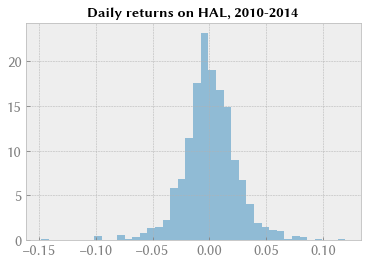

In [8]:
stock = retrieve_stock_data("HAL", "2010-01-01", "2014-01-01")
returns = stock["adjclose"].pct_change().dropna()
mean = returns.mean()
sigma = returns.std()
tdf, tmean, tsigma = scipy.stats.t.fit(returns)
returns.hist(bins=40, density=True, histtype="stepfilled", alpha=0.5)
plt.title("Daily returns on HAL, 2010-2014", weight="bold");

In [9]:
returns.quantile(0.05)

-0.03413508777331733

The 0.05 empirical quantile of daily returns is at -0.034. 

**The 0.05 empirical quantile of daily returns is at -0.034. That means that with 95% confidence, our worst daily loss will not exceed 3.4%. If we have a 1 M€ investment, our one-day 5% VaR is 0.034 * 1 M€ = 34 k€.


## 3.Value at Risk using the variance-covariance method

Method: calculate analytic quantiles by curve fitting to historical data. Here, we use Student’s t distribution (we checked above that it represents daily returns relatively well).

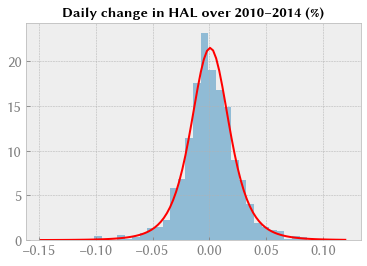

In [10]:
support = numpy.linspace(returns.min(), returns.max(), 100)
returns.hist(bins=40, density=True, histtype="stepfilled", alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title("Daily change in HAL over 2010–2014 (%)", weight="bold");

In [11]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.038358362244308025

Our analytic 0.05 quantile is at -0.0384.

**Our analytic 0.05 quantile is at -0.0384, so with 95% confidence, our worst daily loss will not exceed 3.84%. For a 1 M€ investment, one-day Value at Risk is 0.0384 * 1 M€ = 38 k€.

## 4. Value at Risk using the Monte Carlo method

**Method**: run many trials with random market conditions, calculating portfolio loss for each trial. Use the aggregated trial data to establish a profile of the portfolio’s risk characteristics. 

**Hypothesis**: stock market evolution can be simulated by geometric Brownian motion (this is a rough hypothesis; see the literature on stochastic methods in finance for more sophisticated, and more realistic, models, such as jump diffusion).

We start by defining some parameters of the geometric Brownian motion.

In [12]:
days = 300   # time horizon
dt = 1/float(days)
sigma = 0.04 # volatility
mu = 0.05  # drift (average growth rate)

This function simulates one stock market evolution, and returns the price evolution as an array. It simulates geometric Brownian motion using pseudorandom numbers drawn from a normal distribution.

In [13]:
def random_walk(startprice):
    price = numpy.zeros(days)
    shock = numpy.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = numpy.random.normal(loc=mu * dt, scale=sigma * numpy.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

Let’s simulate 30 random walks, starting from an initial stock price of 10€, for a duration of 300 days.

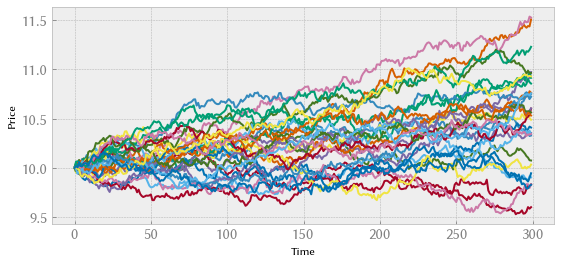

In [14]:
plt.figure(figsize=(9,4))    
for run in range(30):
    plt.plot(random_walk(10.0))
plt.xlabel("Time")
plt.ylabel("Price");

Final price is spread out between 9.5€ (our portfolio has lost value) to almost 12€. We can see graphically that the expectation (mean outcome) is a profit; this is due to the fact that the drift in our random walk (parameter mu) is positive.

Now let’s run a big Monte Carlo simulation of random walks of this type, to obtain the probability distribution of the final price, and obtain quantile measures for the Value at Risk estimation. This will take a little time to run (decrease variable `runs` if you want faster, but less representative, results).

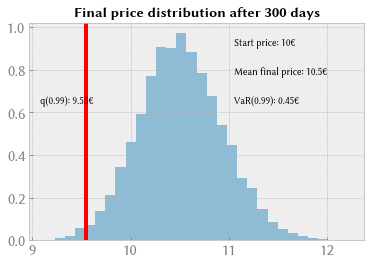

In [15]:
runs = 10_000
simulations = numpy.zeros(runs)
for run in range(runs):
    simulations[run] = random_walk(10.0)[days-1]
q = numpy.percentile(simulations, 1)
plt.hist(simulations, density=True, bins=30, histtype="stepfilled", alpha=0.5)
plt.figtext(0.6, 0.8, "Start price: 10€")
plt.figtext(0.6, 0.7, "Mean final price: {:.3}€".format(simulations.mean()))
plt.figtext(0.6, 0.6, "VaR(0.99): {:.3}€".format(10 - q))
plt.figtext(0.15, 0.6, "q(0.99): {:.3}€".format(q))
plt.axvline(x=q, linewidth=4, color="r")
plt.title("Final price distribution after {} days".format(days), weight="bold");

We have looked at the 1% empirical quantile of the final price distribution to estimate the Value at Risk, which is 0.427€ for a 10€ investment.

## 5. Correlation between stocks

Let's examine the variation of stock indexes in different countries: the CAC40 index which summarizes the price of the 40 largest listed companies on the Paris stock exchange, the DAX which does likewise for the German stock exchange, the Hang Seng Index in Hong Kong and finally the All Ordinaries in Australia. 

We are interested in checking whether these stock indexes are **correlated**: when one goes down, does the other also tend to move in the same direction? See our course notes for the importance of correlation in financial risk analysis. 

In [16]:
start = "2005-01-01"
end   = "2010-01-01"
CAC = retrieve_stock_data("^FCHI", start, end)
DAX = retrieve_stock_data("^GDAXI", start, end)
HSI = retrieve_stock_data("^HSI", start, end)
AORD = retrieve_stock_data("^AORD", start, end)

df = pandas.DataFrame({ "CAC": CAC["adjclose"].pct_change(),
                        "DAX": DAX["adjclose"].pct_change(),
                        "HSI": HSI["adjclose"].pct_change(),
                        "AORD": AORD["adjclose"].pct_change() })
dfna = df.dropna()

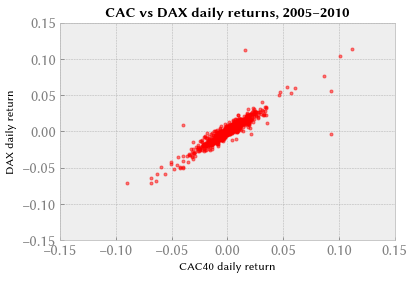

In [17]:
ax = plt.axes()
ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)
plt.plot(dfna["CAC"], dfna["DAX"], "r.", alpha=0.5)
plt.xlabel("CAC40 daily return")
plt.ylabel("DAX daily return")
plt.title("CAC vs DAX daily returns, 2005–2010", weight="bold");

In [18]:
scipy.stats.pearsonr(dfna["CAC"], dfna["DAX"])

(0.9176923741808768, 0.0)

This is a high level of correlation between the French and German indexes. We can interpret this as indicating that large French and German firms are exposed to quite similar opportunities and threats.

**A continuación representmos el Histograma de Rendimientos diarios del CAC y  DAX 

CAC t fit: mean=0.0005614732069055624, scale=0.008993471689559836, df=2.7622973761215905


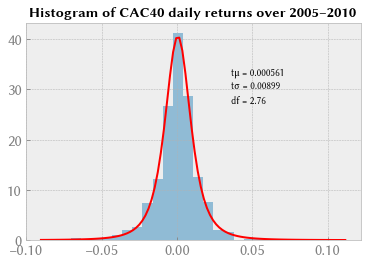

In [21]:
returns = dfna["CAC"]
returns.hist(bins=30, density=True, histtype="stepfilled", alpha=0.5)
support = numpy.linspace(returns.min(), returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(returns)
print("CAC t fit: mean={}, scale={}, df={}".format(tmean, tsigma, tdf))
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.figtext(0.6, 0.7, "tμ = {:.3}".format(tmean))
plt.figtext(0.6, 0.65, "tσ = {:.3}".format(tsigma))
plt.figtext(0.6, 0.6, "df = {:.3}".format(tdf))
plt.title("Histogram of CAC40 daily returns over 2005–2010", weight="bold");

DAX t fit: mean=0.0009648852436396147, scale=0.008832711177617329, df=2.7513935434499297


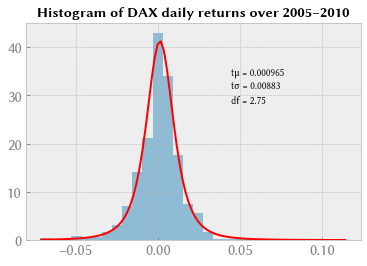

In [22]:
returns = dfna["DAX"]
returns.hist(bins=30, density=True, histtype="stepfilled", alpha=0.5)
support = numpy.linspace(returns.min(), returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(returns)
print("DAX t fit: mean={}, scale={}, df={}".format(tmean, tsigma, tdf))
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.figtext(0.6, 0.7, "tμ = {:.3}".format(tmean))
plt.figtext(0.6, 0.65, "tσ = {:.3}".format(tsigma))
plt.figtext(0.6, 0.6, "df = {:.3}".format(tdf))
plt.title("Histogram of DAX daily returns over 2005–2010", weight="bold");

**Let’s simulate random joint stock returns from a joint distribution of fitted-CAC and fitted-DAX according to the distribution parameters estimated above, and plot the results. We need these simulated joint returns to do a Monte Carlo VaR analysis of a stock portfolio composed of CAC and DAX stock.

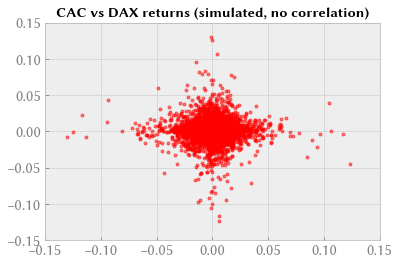

In [23]:
runs = 5000
fittedCAC = numpy.zeros(runs, float)
fittedDAX = numpy.zeros(runs, float)
for i in range(runs):
    fittedCAC[i] = scipy.stats.t.rvs(loc=0.000478137351981, scale=0.00898201242824, df=2.75557323986)
    fittedDAX[i] = scipy.stats.t.rvs(loc=0.000847802944791, scale=0.00878082895409, df=2.71766905436)
ax = plt.axes()
ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)
plt.plot(fittedCAC, fittedDAX, "r.", alpha=0.5)
plt.title("CAC vs DAX returns (simulated, no correlation)", weight="bold");

**Problem**: our sampling from these fitted random variables doesn’t match the observations from the real markets (scroll up to check the real CAC/DAX scatterplot). 
